In [2]:
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

In [4]:
path_train = '/data_lids/home/walter/Lab/alignment/basep/processed/output_064/train'
path_test = '/data_lids/home/walter/Lab/alignment/basep/processed/output_064/test'

In [13]:
# Clase personalizada para cargar el dataset
class FingerprintDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        angle = float(self.image_files[idx].split('_r')[-1].split('.png')[0])
        
        if self.transform:
            image = self.transform(image)
            
        return image, angle


In [14]:
# Definir transformaciones y cargar el dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_dataset = FingerprintDataset(path_train, transform=transform)
test_dataset = FingerprintDataset(path_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# Crear el modelo ViT
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
# Entrenar el modelo
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [17]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

TOLERANCE = 5  # Ajusta según lo que consideres adecuado

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions_train = 0
    total_predictions_train = 0
    
    for images, angles in train_loader:
        images, angles = images.to(device), angles.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calcular "precisión" dentro de la tolerancia para entrenamiento
        correct_predictions_train += torch.sum(torch.abs(outputs - angles) < TOLERANCE).item()
        total_predictions_train += angles.size(0)
    
    train_loss = total_loss/len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_predictions_train / total_predictions_train
    train_accuracies.append(train_accuracy)
    
    # Validación
    model.eval()
    total_val_loss = 0
    correct_predictions_val = 0
    total_predictions_val = 0
    
    with torch.no_grad():
        for images, angles in test_loader:
            images, angles = images.to(device), angles.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, angles)
            
            total_val_loss += loss.item()
            
            # Calcular "precisión" dentro de la tolerancia para validación
            correct_predictions_val += torch.sum(torch.abs(outputs - angles) < TOLERANCE).item()
            total_predictions_val += angles.size(0)
    
    val_loss = total_val_loss/len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_predictions_val / total_predictions_val
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}:\n\tTraining Loss: {train_loss}, Validation Loss: {val_loss}\n\t Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")



Epoch 1/100:
	Training Loss: 156.2393545262954, Validation Loss: 151.7611800549077
	 Training Accuracy: 0.33108315434182267, Validation Accuracy: 0.32699386503067485
Epoch 2/100:
	Training Loss: 150.75579474954043, Validation Loss: 156.67704728070427
	 Training Accuracy: 0.3349186867137159, Validation Accuracy: 0.32699386503067485
Epoch 3/100:
	Training Loss: 153.92978791629568, Validation Loss: 151.5069834391276
	 Training Accuracy: 0.33338447376495856, Validation Accuracy: 0.32699386503067485
Epoch 4/100:
	Training Loss: 151.6477123335296, Validation Loss: 151.45946383008769
	 Training Accuracy: 0.3349186867137159, Validation Accuracy: 0.32699386503067485
Epoch 5/100:
	Training Loss: 150.72494473176843, Validation Loss: 155.1024180393593
	 Training Accuracy: 0.3349186867137159, Validation Accuracy: 0.32699386503067485
Epoch 6/100:
	Training Loss: 150.65929367963005, Validation Loss: 152.34730290431602
	 Training Accuracy: 0.3349186867137159, Validation Accuracy: 0.32699386503067485
E

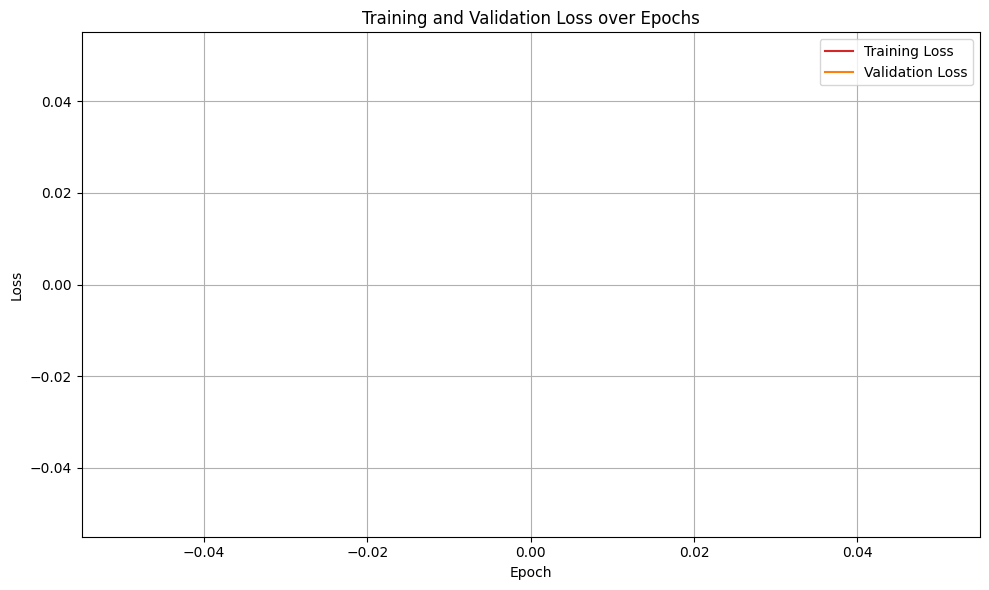

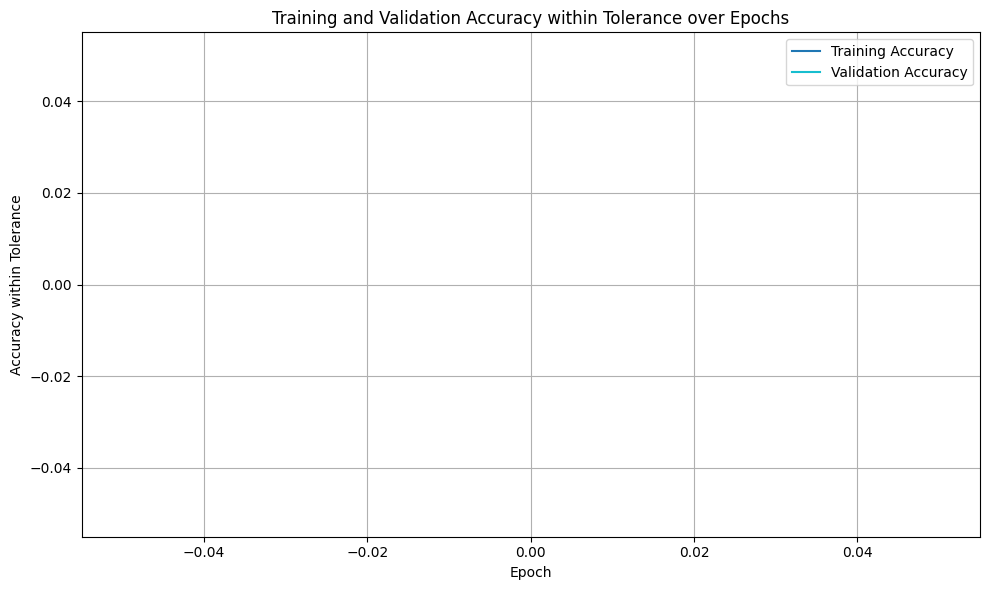

In [12]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='tab:red')
plt.plot(val_losses, label='Validation Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar la "precisión" dentro de la tolerancia para entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='tab:blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='tab:cyan')
plt.xlabel('Epoch')
plt.ylabel('Accuracy within Tolerance')
plt.legend()
plt.title('Training and Validation Accuracy within Tolerance over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()
